In [12]:
import numpy as np
import torch
import pytorch_lightning as pl

In [13]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

4

In [14]:
x = torch.FloatTensor([0,9,7])


In [10]:
x_big = torch.randn(100000)

In [11]:
x_big_gpu = x_big.cuda()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [15]:
x_gpu = x.cuda()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [6]:
x_gpu

tensor([0., 9., 7.], device='cuda:0')

# Data Loading

In [1]:
#Looking at data

data_dir = '/common/home/vk405/Projects/Crossmdl/Data/YouCookII/'
import pandas as pd
import os
label = pd.read_csv(data_dir+'label_foodtype.csv')

In [2]:
label.head()

,101,BLT
0,102,onion rings
1,103,burger
2,104,scrambled eggs
3,105,fried chicken
4,106,macaroni and cheese


In [3]:
splits_dir = data_dir+'splits/'
splits = ['test_list.txt','train_list.txt','val_list.txt']
splits_dir

'/common/home/vk405/Projects/Crossmdl/Data/YouCookII/splits/'

In [4]:
def get_vids(base_dir,split):
    trn_split = base_dir+split
    trn_idlst = []
    trn_vidlst = []

    f = open(trn_split,'r')
    for line in f:
        id_,vid = line.split('/')
        vid = vid.strip('\n')
        trn_idlst.append(id_)
        trn_vidlst.append(vid)
        #print(vid)
        #break
    f.close()
    return trn_idlst,trn_vidlst

In [5]:
feat_dir = '/common/users/vk405/feat_csv'

test_frame_feat_csv  train_frame_feat_csv  val_frame_feat_csv


In [6]:
def get_features(data_dir,split='val',feat_dir='/common/users/vk405/feat_csv/'):
    #feat_dir = data_dir
    splits_dir = data_dir+'splits/'
    if split == 'val':
        feat_split_dir = feat_dir+'val_frame_feat_csv/'  
        vid_num,vid_name = get_vids(splits_dir,'val_list.txt')  
    elif split == 'train':
        feat_split_dir = feat_dir+'train_frame_feat_csv/'  
        vid_num,vid_name = get_vids(splits_dir,'train_list.txt') 
    elif split == 'test':
        feat_split_dir = feat_dir+'test_frame_feat_csv/'  
        vid_num,vid_name = get_vids(splits_dir,'test_list.txt')
    else:
        raise NotImplementedError(f'unknown split: {split}')     
    feat_list = []
    vid_dtls = []
    for num,name in zip(vid_num,vid_name):
        feat_loc = os.path.join(feat_split_dir, f'{num}/{name}/0001/')
        #import pdb;pdb.set_trace()
        if os.path.isdir(feat_loc):
            feat_files = feat_loc + os.listdir(feat_loc)[0]
            feat_list.append(feat_files)
            vid_dtls.append((num,name))
        else:
            print(f"video : {num}/{name} not found")
    return feat_list,vid_dtls

In [7]:
trn_feats,trn_vids = get_features(data_dir,split='train')

In [8]:
trn_vids[:4]

[('405', 'Ysh60eirChU'),
 ('405', 'jpQBWsR3HHs'),
 ('405', 'QWXlKD-XGCQ'),
 ('405', '5E3kulJRzGY')]

In [9]:
trn_feats[:4]

['/common/users/vk405/feat_csv/train_frame_feat_csv/405/Ysh60eirChU/0001/resnet_34_feat_mscoco.csv',
 '/common/users/vk405/feat_csv/train_frame_feat_csv/405/jpQBWsR3HHs/0001/resnet_34_feat_mscoco.csv',
 '/common/users/vk405/feat_csv/train_frame_feat_csv/405/QWXlKD-XGCQ/0001/resnet_34_feat_mscoco.csv',
 '/common/users/vk405/feat_csv/train_frame_feat_csv/405/5E3kulJRzGY/0001/resnet_34_feat_mscoco.csv']

## Extracting labels

In [50]:
sample_feat = pd.read_csv(trn_feats[0])
sample_feat.head()

,0.23554123938084,0.38126820325851,0.037564814090729,0.33999225497246,0.079771302640438,0.16590736806393,0.044274087995291,0.24475057423115,0,0.058666735887527,...,0.084935463964939,0.01984204351902,0.32,0.097782678902149,0.066549979150295,0.027964554727077,0.07146405428648,0.2452535033226,0.57338571548462,0.107208378613
0,0.223362,0.522559,0.054025,0.235792,0.337412,0.071114,0.698125,0.454669,0.117050,0.400916,...,0.608820,0.098003,0.065165,0.009080,0.000075,0.177700,0.010139,0.240321,0.834141,0.531293
1,0.280908,0.799305,0.116399,0.149240,0.490649,0.493386,0.203430,0.271588,0.432822,0.227877,...,0.705037,0.407644,0.328168,0.064713,0.034681,0.718221,0.673627,0.113452,0.316431,0.316319
2,0.337408,0.787760,0.175948,0.201669,0.449441,0.568926,0.243045,0.220369,0.737802,0.207814,...,0.692446,0.500816,0.315559,0.016786,0.029962,0.545505,0.654320,0.106729,0.551245,0.189272
3,0.320235,0.798259,0.162805,0.165569,0.482295,0.588328,0.242836,0.243118,0.740177,0.206619,...,0.675599,0.469745,0.359901,0.011614,0.028526,0.611490,0.676336,0.115364,0.544628,0.194859
4,0.158559,0.524380,0.109580,0.487074,0.136141,0.003217,0.807754,0.140633,0.451391,0.053430,...,0.399409,0.149640,0.000000,0.150264,0.011508,0.348237,0.253195,0.152878,0.720622,0.603298


In [36]:
shapes = []
for file in val_feats:
    f = pd.read_csv(file)
    pres_shape = f.shape
    if len(shapes):
        if shapes[-1] != pres_shape:
            print('shape mismatch')
    shapes.append(pres_shape)
        

In [10]:
annotns_file = data_dir+'annotations/youcookii_annotations_trainval.json'


In [11]:
import json


def get_raw_labels(ids):

    label_info = {}
    with open(annotns_file) as json_file:
        annotns = json.load(json_file)
        print(annotns.keys())
        for _,vidname in ids:
            #import pdb;pdb.set_trace()
            if vidname in annotns['database']:
                #import pdb;pdb.set_trace()
                duration = annotns['database'][vidname]['duration']
                annot = annotns['database'][vidname]['annotations']
                labels = []
                #import pdb;pdb.set_trace()
                for segment_info in annot:
                    interval = segment_info['segment']
                    sent = segment_info['sentence']
                    labels.append((interval,sent,duration))

                label_info[vidname] = labels
            else:
                print(f"label for {vidname} not present")
    return label_info
    
    
label_info = get_raw_labels(trn_vids)

dict_keys(['database'])


In [12]:
label_info['Ysh60eirChU']

[([120, 125], 'heat 2 tbsp ghee in a pan', 609.97),
 ([128, 198],
  'add cinnamon bay leaves green cardamoms black cardamoms green chillies and saute',
  609.97),
 ([222, 244], 'add onions and saute for 3-4 minutes', 609.97),
 ([263, 300], 'add mutton and saute for 2 minutes', 609.97),
 ([302, 308], 'add ginger-garlic paste and mix well', 609.97),
 ([309, 343],
  'add salt 2 cup water and cover to pressure cook on high heat for 5 minutes',
  609.97),
 ([395, 428],
  'heat crushed peppercorns and cashew nut paste with remaining ghee in a pan',
  609.97),
 ([475, 500],
  'add the cooked mutton with stock and spices and mix everything well',
  609.97),
 ([508, 529], 'add garam masala powder cream and stir to mix', 609.97),
 ([570, 573], 'sprinkle crushed peppercorns on top and serve', 609.97)]

In [13]:
intervals = []
for ele in label_info.values():
    for intv,_ ,_ in ele:
        intervals.append(intv)
    

In [14]:
from itertools import chain

min(list(chain(*intervals))),max(list(chain(*intervals)))

(0, 1046)

In [16]:
def regress_labels(raw_labels):
    regress_labels = {}
    for key in raw_labels:
        new_labels = []
        for item in raw_labels[key]:
            rng,sent,vidlen = item
            mid = sum(rng)/2
            duration = rng[-1]-rng[0]
            mid_pred = (1/vidlen)*mid # location of mid-point w.r.t video length
            duration_pred = (1/vidlen)*duration
            new_labels.append(([mid_pred,duration_pred],sent))
        regress_labels[key] = new_labels
    return regress_labels
            
            
    

In [17]:
final_labels = regress_labels(label_info)

In [19]:
final_labels['Ysh60eirChU']

[([0.20082954899421282, 0.00819712444874338], 'heat 2 tbsp ghee in a pan'),
 ([0.2672262570290342, 0.11475974228240732],
  'add cinnamon bay leaves green cardamoms black cardamoms green chillies and saute'),
 ([0.3819859993114415, 0.03606734757447087],
  'add onions and saute for 3-4 minutes'),
 ([0.46149810646425227, 0.060658720920701015],
  'add mutton and saute for 2 minutes'),
 ([0.5000245913733462, 0.009836549338492056],
  'add ginger-garlic paste and mix well'),
 ([0.5344525140580684, 0.05574044625145498],
  'add salt 2 cup water and cover to pressure cook on high heat for 5 minutes'),
 ([0.6746233421315802, 0.05410102136170631],
  'heat crushed peppercorns and cashew nut paste with remaining ghee in a pan'),
 ([0.7992196337524795, 0.0409856222437169],
  'add the cooked mutton with stock and spices and mix everything well'),
 ([0.8500418053346885, 0.034427922684722195],
  'add garam masala powder cream and stir to mix'),
 ([0.9369313244913683, 0.004918274669246028],
  'sprinkle c

In [23]:
len(final_labels.keys()),len(trn_feats)

(1333, 1333)

In [24]:
#tokenizing sentences

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 41.1kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 853kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 6.48MB/s]
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 8.06MB/s]


In [26]:
from transformers import AutoModel
import torch
model_ckpt = "bert-base-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)



Downloading: 100%|██████████| 416M/416M [00:13<00:00, 32.2MB/s] 
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs


inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    #get the embedding corresponding to CLS tokes or the sentence
    last_hidden_state[:,0]


Input tensor shape: torch.Size([1, 6])


In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}







In [2]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
last_hidden_states 

NameError: name 'last_hidden_states' is not defined

# EDA

In [ ]:
# Text length statistics - train

label_info

In [153]:
from collections import defaultdict
def extract_stats(label_dict,tokenizer=None):
    txt_len = []
    duration = []
    total_len = []
    vocab = defaultdict(int)
    for key in label_dict:
        for i,ele in enumerate(label_dict[key]):
            rng,sent,tot_ln = ele
            if tokenizer:
                words = tokenizer.tokenize(sent)
            else:
                words = sent.split(' ')
            for wrd in words:
                vocab[wrd] += 1
            txt_len.append(len(words))
            duration.append(rng[-1]-rng[0])
            if i==0:
                total_len.append(tot_ln)
    return {'txt_len':txt_len,'duration':duration,'total_len':total_len,'vocab':vocab}
            
                
            

In [84]:
stats = extract_stats(label_info)

In [98]:
from collections import Counter

txt_lens = Counter(stats['txt_len'])
txt_df = pd.DataFrame({'lens':list(txt_lens.keys()),'freq':list(txt_lens.values())})


duration_lens = Counter(stats['duration'])
duration_df = pd.DataFrame({'lens':list(duration_lens.keys()),'freq':list(duration_lens.values())})


In [100]:
import altair as alt

alt.Chart(txt_df).mark_bar().encode(
    x='lens',
    y='freq'
)

alt.Chart(...)

In [110]:
import altair as alt

alt.Chart(duration_df).mark_bar().encode(
    x='lens',
    y='freq'
)


alt.Chart(...)

In [106]:
vocab_stats = pd.DataFrame({'words':list(stats['vocab'].keys()),'freq':list(stats['vocab'].values())})

In [115]:
total_cnt = sum(vocab_stats.sort_values(by='freq',ascending=False)['freq'])

vocab_stats['frac_contrib'] = vocab_stats['freq']/total_cnt

In [118]:
sorted_vocab = vocab_stats.sort_values(by='freq',ascending=False)

In [122]:
sorted_vocab['cum_frac'] = sorted_vocab['frac_contrib'].cumsum()

In [125]:
sorted_vocab[sorted_vocab['cum_frac']<0.95]

,words,freq,frac_contrib,cum_frac
42,the,9451,0.104037,0.104037
15,and,7350,0.080909,0.184945
7,add,4151,0.045694,0.230640
30,to,2865,0.031538,0.262178
5,a,2494,0.027454,0.289632
...,...,...,...,...
640,smoked,11,0.000121,0.949418
310,cherry,11,0.000121,0.949539
715,squares,11,0.000121,0.949660
1475,scramble,11,0.000121,0.949781


In [150]:
# Tokenization and other text specific handling.
#!pip install datasets  # You can install custom packages on Google Colab by !pip install ... 
#!pip install transformers
#nltk.download()


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

class Tokenizer:
    def __init__(self, tokenize_type='basic', lowercase=False,stopwords=None):
        self.tokenize_type = tokenize_type
        self.lowercase = lowercase
        self.digits = set([str(i) for i in range(10)])
        if stopwords:
            self.digits.update(stopwords)
        if self.tokenize_type == 'wp':
            self.wptok = BertTokenizer.from_pretrained('bert-base-cased')
            

    def tokenize(self, string):
        if self.lowercase:
            string = string.lower()
        if self.tokenize_type == 'basic':
            tokens = string.split()
        elif self.tokenize_type == 'nltk':
            tokens = nltk.tokenize.word_tokenize(string)
        elif self.tokenize_type == 'wp':
            tokens = self.wptok.tokenize(string)
        else:
            raise ValueError('Unknown tokenization type.')
        tokens = [tok for tok in tokens if tok not in self.digits]
        return tokens




In [151]:
tknr = Tokenizer(lowercase=True,stopwords=ENGLISH_STOP_WORDS)

In [152]:
samplevid = final_labels['Ysh60eirChU']

for ele in samplevid:
    _,sent = ele
    tokens = tknr.tokenize(sent)
    print('*****************')
    print(sent)
    print(tokens)

*****************
heat 2 tbsp ghee in a pan
['heat', 'tbsp', 'ghee', 'pan']
*****************
add cinnamon bay leaves green cardamoms black cardamoms green chillies and saute
['add', 'cinnamon', 'bay', 'leaves', 'green', 'cardamoms', 'black', 'cardamoms', 'green', 'chillies', 'saute']
*****************
add onions and saute for 3-4 minutes
['add', 'onions', 'saute', '3-4', 'minutes']
*****************
add mutton and saute for 2 minutes
['add', 'mutton', 'saute', 'minutes']
*****************
add ginger-garlic paste and mix well
['add', 'ginger-garlic', 'paste', 'mix']
*****************
add salt 2 cup water and cover to pressure cook on high heat for 5 minutes
['add', 'salt', 'cup', 'water', 'cover', 'pressure', 'cook', 'high', 'heat', 'minutes']
*****************
heat crushed peppercorns and cashew nut paste with remaining ghee in a pan
['heat', 'crushed', 'peppercorns', 'cashew', 'nut', 'paste', 'remaining', 'ghee', 'pan']
*****************
add the cooked mutton with stock and spices an

In [154]:
# lets look at word statistics with tokenization
tknr = Tokenizer(lowercase=True,stopwords=ENGLISH_STOP_WORDS)
stats_updtd = extract_stats(label_info,tokenizer=tknr)

In [156]:

vocab_stats_updtd = pd.DataFrame({'words':list(stats_updtd['vocab'].keys()),'freq':list(stats_updtd['vocab'].values())})

In [184]:
sum(vocab_stats_updtd['freq']>=2)

1306

We might just need around 1000 tokens.

In [189]:
vocab_stats_updtd[vocab_stats_updtd['freq']<2].head()

,words,freq
17,ginger-garlic,1
30,nut,1
61,leavese,1
62,colves,1
64,turmac,1


# Modeling

In [196]:
#trn_feats,trn_vids,final_labels
import torch
import numpy as np
import random
def set_seed(seed):  # For reproducibility, fix random seeds.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [191]:
sample_feat = pd.read_csv(trn_feats[0]).values

In [34]:
#!pip install transformers

def init_parameters_xavier_uniform(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def scaled_dot(query, key, mask_key=None):  
    score = torch.matmul(query, key.transpose(-2, -1))
    score /= math.sqrt(query.size(-1))
    if mask_key is not None:
        score = score.masked_fill(mask_key, -1e18)  # Represents negative infinity
    return score      
            
def attend(query, key, value, mask_key=None, dropout=None):
    # TODO: Implement
    # Use scaled_dot, be sure to mask key
    #smax = nn.Softmax(-1)
    #import pdb;pdb.set_trace()
    score = scaled_dot(query,key,mask_key)  
    attention = F.softmax(score,dim=-1)
    if dropout is not None:#do = nn.Dropout(dropout)
        attention = dropout(attention)
    answer = torch.matmul(attention,value) 
    # Convexly combine value embeddings using attention, this should be just a matrix-matrix multiplication.
    return answer, attention

In [35]:
def split_heads(batch, num_heads):  
    (batch_size, length, dim) = batch.size()  # These are the expected batch dimensions.
    assert dim % num_heads == 0  # Assert that dimension is divisible by the number of heads.
    dim_head = dim // num_heads

    # No new memory allocation
    splitted = batch.view(batch_size, -1, num_heads, dim_head).transpose(1, 2)  
    return splitted  # (batch_size, num_heads, length, dim_head), note that now the last two dimensions are compatible with our attention functions. 




def merge_heads(batch):  
    (batch_size, num_heads, length, dim_head) = batch.size()  # These are the expected batch dimensions.

    # New memory allocation (reshape), can't avoid.
    merged = batch.transpose(1, 2).reshape(batch_size, -1, num_heads * dim_head)
    return merged  # (batch_size, length, dim)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout_rate=0.1):
        super().__init__()
        assert dim % num_heads == 0

        self.linear_query = nn.Linear(dim, dim)
        self.linear_key = nn.Linear(dim, dim)
        self.linear_value = nn.Linear(dim, dim)
        self.linear_final = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.num_heads = num_heads

    def forward(self, query, key, value, mask_key=None, layer_cache=None,
              memory_attention=False):
        """
        INPUT
          query: (batch_size, length_query, dim)
          key: (batch_size, length_key, dim)
          value: (batch_size, length_key, dim_value)
          mask_key: (*, 1, length_key) if queries share the same mask, else
                    (*, length_query, length_key)
          layer_cache: if not None, stepwise decoding (cache of key/value)
          memory_attention: doing memory attention in stepwise decoding?
        OUTPUT
          answer: (batch_size, length_query, dim_value)
          attention: (batch_size, num_heads, length_query, length_key) else
        """
        batch_size = query.size(0)

        query = self.linear_query(query)
        query = split_heads(query, self.num_heads)  # (batch_size, num_heads, -1, dim_head)

        def process_key_value(key, value):  # Only called when necessary.
            key = self.linear_key(key)
            key = split_heads(key, self.num_heads)
            value = self.linear_value(value)
            value = split_heads(value, self.num_heads)
            return key, value

        #import pdb;pdb.set_trace()
        if layer_cache is None:
            key, value = process_key_value(key, value)
        else:
            assert query.size(2) == 1  # Stepwise decoding
            
            if memory_attention:
                if layer_cache['memory_key'] is None:  # One-time calculation
                    key, value = process_key_value(key, value)
                    # (batch_size, num_heads, length_memory, dim)
                    layer_cache['memory_key'] = key
                    layer_cache['memory_value'] = value

                key = layer_cache['memory_key']
                value = layer_cache['memory_value']

            else:  # Self-attention during decoding
                key, value = process_key_value(key, value)
                assert key.size(2) == 1 and value.size(2) == 1
                
                # Append to previous.
                if layer_cache['self_key'] is not None:
                    key = torch.cat((layer_cache['self_key'], key), dim=2)
                    value = torch.cat((layer_cache['self_value'], value), dim=2)
                    
                 # (batch_size, num_heads, length_decoded, dim)
                layer_cache['self_key'] = key  # Recache.
                layer_cache['self_value'] = value
        # Because we've splitted embeddings into heads, we must also split the mask. 
        # And because each query uses the same mask for all heads (we don't use different masking for different heads), 
        # we can specify length 1 for the head dimension.
        if mask_key is not None:  
            mask_key = mask_key.unsqueeze(1)  # (batch_size, 1, -1, length_key)

        answer, attention = attend(query, key, value, mask_key, self.dropout)

        answer = merge_heads(answer)  # (batch_size, length_key, dim)
        answer = self.linear_final(answer)

        return answer, attention

In [36]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F


class PositionwiseFeedForward(nn.Module):
    def __init__(self, dim, dim_hidden, drop_rate=0.1):
        super().__init__()
        self.w1 = nn.Linear(dim, dim_hidden)
        self.w2 = nn.Linear(dim_hidden, dim)
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.drop1 = nn.Dropout(drop_rate)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(drop_rate)
    def forward(self, x):
        inter = self.drop1(self.relu(self.w1(self.layer_norm(x))))
        output = self.drop2(self.w2(inter))
        return output + x


class SinusoidalPositioner(nn.Module):
    def __init__(self, dim, drop_rate=0.1, length_max=5000):
        super().__init__()
        frequency = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.) / dim))  # Using different frequency for each dim
        positions = torch.arange(0, length_max).unsqueeze(1)
        wave = torch.zeros(length_max, dim)
        wave[:, 0::2] = torch.sin(frequency * positions)
        wave[:, 1::2] = torch.cos(frequency * positions)
        self.register_buffer('wave', wave.unsqueeze(0))  # (1, length_max, dim)
        self.dropout = nn.Dropout(drop_rate)
        self.dim = dim
        self.length_max = length_max
    def forward(self, x, step=-1):
        assert x.size(-2) <= self.length_max

        if step < 0:  # Take the corresponding leftmost embeddings.
            position_encoding = self.wave[:, :x.size(-2), :]
        else:  # Take the embedding at the step.
            position_encoding = self.wave[:, step, :]

        x = x * math.sqrt(self.dim)
        return self.dropout(x + position_encoding)





In [37]:
positioner = SinusoidalPositioner(4, drop_rate=0., length_max=5)

Precomputed 100 position embeddings of dim 10, first few:
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
          9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
          9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
          9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
          9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00]])


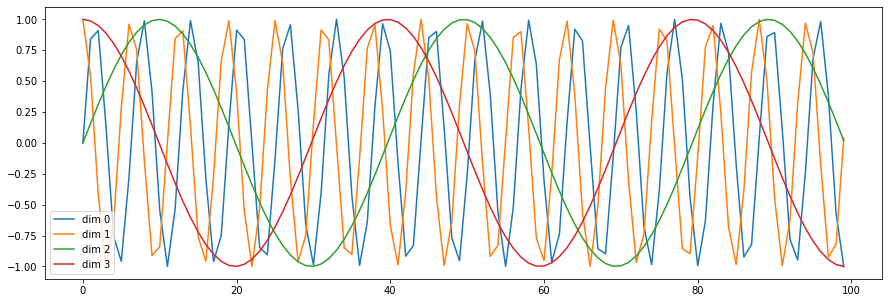

In [38]:
import matplotlib.pyplot as plt
import numpy as np
dim = 10
length_max = 100
positioner = SinusoidalPositioner(dim, drop_rate=0., length_max=length_max)
print('Precomputed %d position embeddings of dim %d, first few:' % (length_max, positioner.dim))
print(positioner.wave[0, 0:5, :])
plt.figure(figsize=(15, 5))
plt.plot(np.arange(length_max), positioner.wave[0, :, 0:4].data.numpy())
plt.legend(["dim %d"%p for p in [0,1,2,3]])

positioned_embeddings = positioner(torch.randn(1, 3, dim))  # Training use case
positioned_embedding = positioner(torch.randn(1, 1, dim), step=0)  # Inference use case

In [51]:
mh_crossatn = MultiHeadAttention(500,2)

source = torch.randn(1,500,500)
tgt = torch.randn(1,1,500)

In [52]:
output,_ = mh_crossatn(tgt,source,source)

In [56]:
output.shape

torch.Size([1, 1, 500])

In [53]:
mh_crossatn

MultiHeadAttention(
  (linear_query): Linear(in_features=500, out_features=500, bias=True)
  (linear_key): Linear(in_features=500, out_features=500, bias=True)
  (linear_value): Linear(in_features=500, out_features=500, bias=True)
  (linear_final): Linear(in_features=500, out_features=500, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [54]:
total_params = lambda model : sum(p.numel() for p in model.parameters() if p.requires_grad)

In [58]:
total_params(mh_crossatn)

1002000

In [ ]:
class TransformerEncoderLayer(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate):
    super().__init__()
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.self_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.drop = nn.Dropout(drop_rate)
    self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)

  def forward(self, source, mask_source=None):
    # TODO: Implement
    #print(source.shape)
    normed = self.layer_norm(source)  
    # Apply layer norm on source

    attended, attention = self.self_attention(normed,normed,normed,mask_source)
    #None, None  # Apply self-attention on normed (be sure to use mask_source).
    attended = self.drop(attended) + source  
    # Re-write attended by applying dropout and adding a residual connection to source.
    return self.feedforward(attended), attention

In [59]:
class CrossAttentionLayer(nn.Module):
    def __init__(self,dim,num_heads,dim_hidden,drop_rate):
        super().__init__()
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.context_attention = MultiHeadAttention(dim, num_heads, drop_rate)
        self.drop = nn.Dropout(drop_rate)
        self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)
        
    def forward(self,target,memory,layer_cache=None):
        
        cross_attn_target = self.layer_norm(target)
        attended, attention = self.context_attention(cross_attn_target,memory,memory,layer_cache=layer_cache,memory_attention=True)
        
        attended = target + self.drop(attended)
        
        return self.feedforward(attended),attention


    

In [67]:
layer_cache = {'memory_key': None, 'memory_value': None, 'self_key': None, 'self_value': None}



source = torch.randn(1,500,50)
tgt = torch.randn(1,1,50)

mh_crossatn = CrossAttentionLayer(50,2,10,0.0)


In [68]:
out,attntion = mh_crossatn(tgt,source,layer_cache=layer_cache)

In [69]:
out.shape

torch.Size([1, 1, 50])

In [66]:
attntion.shape

torch.Size([1, 2, 1, 500])

In [70]:
total_params(mh_crossatn)

11460

During training we train one video at a time,with each output-embedding leading to a regression loss. As a preprocessing step we can run 1d-conv to control for dimensionality. The sequence length will still be 500 - thus leading to high parameter count.Use a 1d-cnn to reduce the dimensionality.